# Claim Severity Modeling Pipeline

This notebook implements a comprehensive machine learning pipeline for predicting claim severity in insurance data. The model focuses on predicting the financial impact of claims (TotalClaims) for policies that have experienced claims.


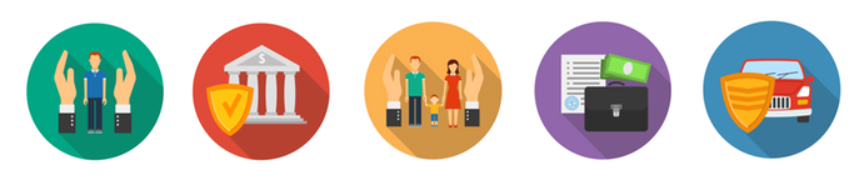

## Business Objective
- **Primary Goal**: Predict the financial impact of claims to support reserving and pricing decisions
- **Risk Assessment**: Identify key factors that drive claim severity
- **Strategic Value**: Enable risk-based pricing and improve underwriting processes

## Table of Contents
1. [Environment Setup and Imports](#setup)
2. [Data Loading and Initial Exploration](#loading)
3. [Data Preprocessing Pipeline](#preprocessing)
4. [Feature Engineering](#feature-engineering)
5. [Data Encoding and Preparation](#encoding)
6. [Train-Test Split and Scaling](#splitting)
7. [Feature Selection](#feature-selection)
8. [Model Training](#training)
9. [Model Evaluation](#evaluation)
10. [Model Comparison and Selection](#comparison)
11. [Performance Visualization](#visualization)
12. [Model Interpretation](#interpretation)
13. [SHAP Analysis](#shap)
14. [Business Insights](#insights)
15. [Model Persistence](#persistence)
16. [Final Summary](#summary)

## 1. Environment Setup and Imports {#setup}

Setting up the required libraries and modules for the claim severity modeling pipeline. This includes data manipulation, visualization, machine learning, and custom modeling utilities.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# Add src to Python path
sys.path.append('../src')

from modeling.data_preprocessor import DataPreprocessor
from modeling.feature_engineer import FeatureEngineer
from modeling.model_trainer import ModelTrainer
from modeling.model_evaluator import ModelEvaluator
from modeling.model_interpreter import ModelInterpreter

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

## 2. Data Loading and Initial Exploration {#loading}

Loading the insurance dataset and performing initial exploration to understand the data structure, dimensions, and available features for claim severity modeling.

In [4]:
# Load the data
print("Loading insurance data...")
data = pd.read_csv('../data/raw/insurance_data.csv')  # Adjust path as needed
print(f"Data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Loading insurance data...
Data shape: (1000098, 52)
Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']


## 3. Data Preprocessing Pipeline {#preprocessing}

Initializing the preprocessing pipeline and preparing the dataset specifically for claim severity modeling. This involves filtering the data to include only policies with claims (TotalClaims > 0) since we're modeling severity, not frequency.

In [5]:
# Initialize preprocessing pipeline
preprocessor = DataPreprocessor(random_state=42)
feature_engineer = FeatureEngineer()

print("Preparing claim severity dataset...")
# Prepare data for claim severity modeling (only policies with claims)
claim_data = preprocessor.prepare_claim_severity_data(data)
print(f"Claim severity dataset shape: {claim_data.shape}")

INFO:modeling.data_preprocessor:Claim severity dataset: 2788 records with claims


Preparing claim severity dataset...


INFO:modeling.data_preprocessor:Missing values handled. Remaining missing: 0


Claim severity dataset shape: (2788, 54)


## 4. Feature Engineering {#feature-engineering}

Creating advanced features to enhance model performance. This includes risk-based features and interaction terms that can capture complex relationships in the insurance data.

In [6]:
# Feature Engineering
print("Engineering features...")

claim_data = feature_engineer.create_risk_features(claim_data)
claim_data = feature_engineer.create_interaction_features(claim_data)

print(f"Data shape after feature engineering: {claim_data.shape}")

Engineering features...
👉 Bin edges (deduplicated): [np.float64(34000.0), 217868.57034901367, np.float64(450000.0)]
⚠️ Not enough unique bin edges after deduplication. Using equal-width fallback.
Data shape after feature engineering: (2788, 72)


## 5. Data Encoding and Preparation {#encoding}

Encoding categorical variables using a mixed strategy approach and preparing the feature matrix and target variable for model training. This step ensures all features are in a numerical format suitable for machine learning algorithms.

In [7]:
# Data preprocessing
print("Encoding categorical features...")
claim_data_encoded = preprocessor.encode_categorical_features(claim_data, encoding_strategy='mixed')

# Prepare features and target
# Remove target and other non-feature columns
exclude_columns = ['TotalClaims', 'PolicyID', 'UnderwrittenCoverID', 'TransactionMonth']
feature_columns = [col for col in claim_data_encoded.columns if col not in exclude_columns]

X = claim_data_encoded[feature_columns]
y = claim_data_encoded['TotalClaims']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Encoding categorical features...
Feature matrix shape: (2788, 108)
Target variable shape: (2788,)


## 6. Train-Test Split and Feature Scaling {#splitting}

Splitting the dataset into training and testing sets with an 80-20 split, followed by feature scaling to normalize the data. This ensures fair model training and evaluation while preventing data leakage.

In [8]:
# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = preprocessor.split_data(X, y, test_size=0.2)

# Scale features
X_train_scaled, X_test_scaled = preprocessor.scale_features(X_train, X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Splitting data into train and test sets...
Training set shape: (2230, 108)
Test set shape: (558, 108)


## 7. Feature Selection {#feature-selection}

Performing feature selection using mutual information to identify the most relevant features for claim severity prediction. This reduces dimensionality and improves model interpretability while maintaining predictive power.

In [9]:
# Feature Selection
print("Performing feature selection...")
X_train_selected, selected_features = feature_engineer.select_features(
    X_train_scaled, y_train, method='mutual_info', k=20, problem_type='regression'
)

# Apply same feature selection to test set
X_test_selected = X_test_scaled[selected_features]

print(f"Selected features: {selected_features}")
print(f"Reduced feature matrix shape: {X_train_selected.shape}")

Performing feature selection...


INFO:modeling.feature_engineer:Selected 20 features using mutual_info


Selected features: ['PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'cubiccapacity', 'VehicleIntroDate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverCategory', 'TotalPremium', 'PremiumToValueRatio', 'SumInsuredToValueRatio', 'TotalPremium_x_SumInsured', 'TotalPremium_div_SumInsured', 'CoverType_Income Protector', 'CoverType_Own Damage', 'CoverType_Windscreen', 'CoverGroup_Income Protector', 'Section_Motor Comprehensive', 'Section_Optional Extended Covers']
Reduced feature matrix shape: (2230, 20)


## 8. Model Training {#training}

Training multiple machine learning models for claim severity prediction. This includes various regression algorithms to find the best performing model for our specific use case. Hyperparameter tuning can be enabled for optimal performance.

In [10]:
# Model Training
print("Training multiple models for claim severity prediction...")

model_trainer = ModelTrainer(random_state=42)

# Train all models (without hyperparameter tuning for speed, but you can enable it)
models = model_trainer.train_all_models(
    X_train_selected, y_train, 
    problem_type='regression', 
    tune_hyperparameters=False,  # Set to True for better performance
    cv_folds=5
)

print("Model training completed!")

INFO:modeling.model_trainer:Training all models for regression task...
INFO:modeling.model_trainer:Training Linear Regression model...
INFO:modeling.model_trainer:Linear Regression CV RMSE: 33218.2310 ± 18046.7279
INFO:modeling.model_trainer:Training Decision Tree for regression...


Training multiple models for claim severity prediction...


INFO:modeling.model_trainer:Decision Tree CV RMSE: 44722.1838 ± 16018.5992
INFO:modeling.model_trainer:Training Random Forest for regression...
INFO:modeling.model_trainer:Random Forest CV RMSE: 32786.8495 ± 17075.2124
INFO:modeling.model_trainer:Training XGBoost for regression...
INFO:modeling.model_trainer:XGBoost CV RMSE: 35262.7993 ± 17780.3880


Model training completed!


## 9. Model Evaluation {#evaluation}

Evaluating all trained models using comprehensive regression metrics including RMSE, R², MAE, and MAPE. This provides a thorough assessment of each model's performance on the test dataset.

In [11]:
# Model Evaluation
print("Evaluating models...")

evaluator = ModelEvaluator()

evaluation_results = {}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    eval_result = evaluator.evaluate_regression_model(
        model, model_name, X_test_selected, y_test, y_train, X_train_selected
    )
    evaluation_results[model_name] = eval_result

INFO:modeling.model_evaluator:Evaluating regression model: linear_regression
INFO:modeling.model_evaluator:linear_regression - RMSE: 33635.7099, R²: 0.2965, MAPE: 308.91%
INFO:modeling.model_evaluator:Evaluating regression model: decision_tree
INFO:modeling.model_evaluator:decision_tree - RMSE: 39449.0528, R²: 0.0323, MAPE: 272.79%
INFO:modeling.model_evaluator:Evaluating regression model: random_forest


Evaluating models...

Evaluating linear_regression...

Evaluating decision_tree...

Evaluating random_forest...


INFO:modeling.model_evaluator:random_forest - RMSE: 34373.1839, R²: 0.2653, MAPE: 262.06%
INFO:modeling.model_evaluator:Evaluating regression model: xgboost
INFO:modeling.model_evaluator:xgboost - RMSE: 36325.8083, R²: 0.1795, MAPE: 270.66%



Evaluating xgboost...


## 10. Model Comparison and Selection {#comparison}

Comparing all models based on key performance metrics to identify the best performing model. The comparison includes RMSE and R² scores to ensure both accuracy and explanatory power are considered.

In [12]:
# Model Comparison
print("\nModel Comparison Results:")
comparison_df = evaluator.compare_models(metric='rmse', problem_type='regression')
print(comparison_df)

# Also compare R² scores
r2_comparison = evaluator.compare_models(metric='r2_score', problem_type='regression')
print("\nR² Score Comparison:")
print(r2_comparison)

INFO:modeling.model_evaluator:Model comparison based on rmse:
INFO:modeling.model_evaluator:linear_regression: 33635.7099
INFO:modeling.model_evaluator:random_forest: 34373.1839
INFO:modeling.model_evaluator:xgboost: 36325.8083
INFO:modeling.model_evaluator:decision_tree: 39449.0528
INFO:modeling.model_evaluator:Model comparison based on r2_score:
INFO:modeling.model_evaluator:linear_regression: 0.2965
INFO:modeling.model_evaluator:random_forest: 0.2653
INFO:modeling.model_evaluator:xgboost: 0.1795
INFO:modeling.model_evaluator:decision_tree: 0.0323



Model Comparison Results:
               model metric         value
0  linear_regression   rmse  33635.709926
2      random_forest   rmse  34373.183909
3            xgboost   rmse  36325.808254
1      decision_tree   rmse  39449.052761

R² Score Comparison:
               model    metric     value
0  linear_regression  r2_score  0.296526
2      random_forest  r2_score  0.265340
3            xgboost  r2_score  0.179502
1      decision_tree  r2_score  0.032346


## 11. Performance Visualization {#visualization}

Creating comprehensive visualizations for the best performing model including prediction vs actual plots, residual analysis, and other diagnostic charts to assess model quality and identify potential issues.


Creating evaluation plots for best model: linear_regression


INFO:modeling.model_evaluator:Regression plots saved to ../reports/figures/modeling/linear_regression_regression_evaluation.png


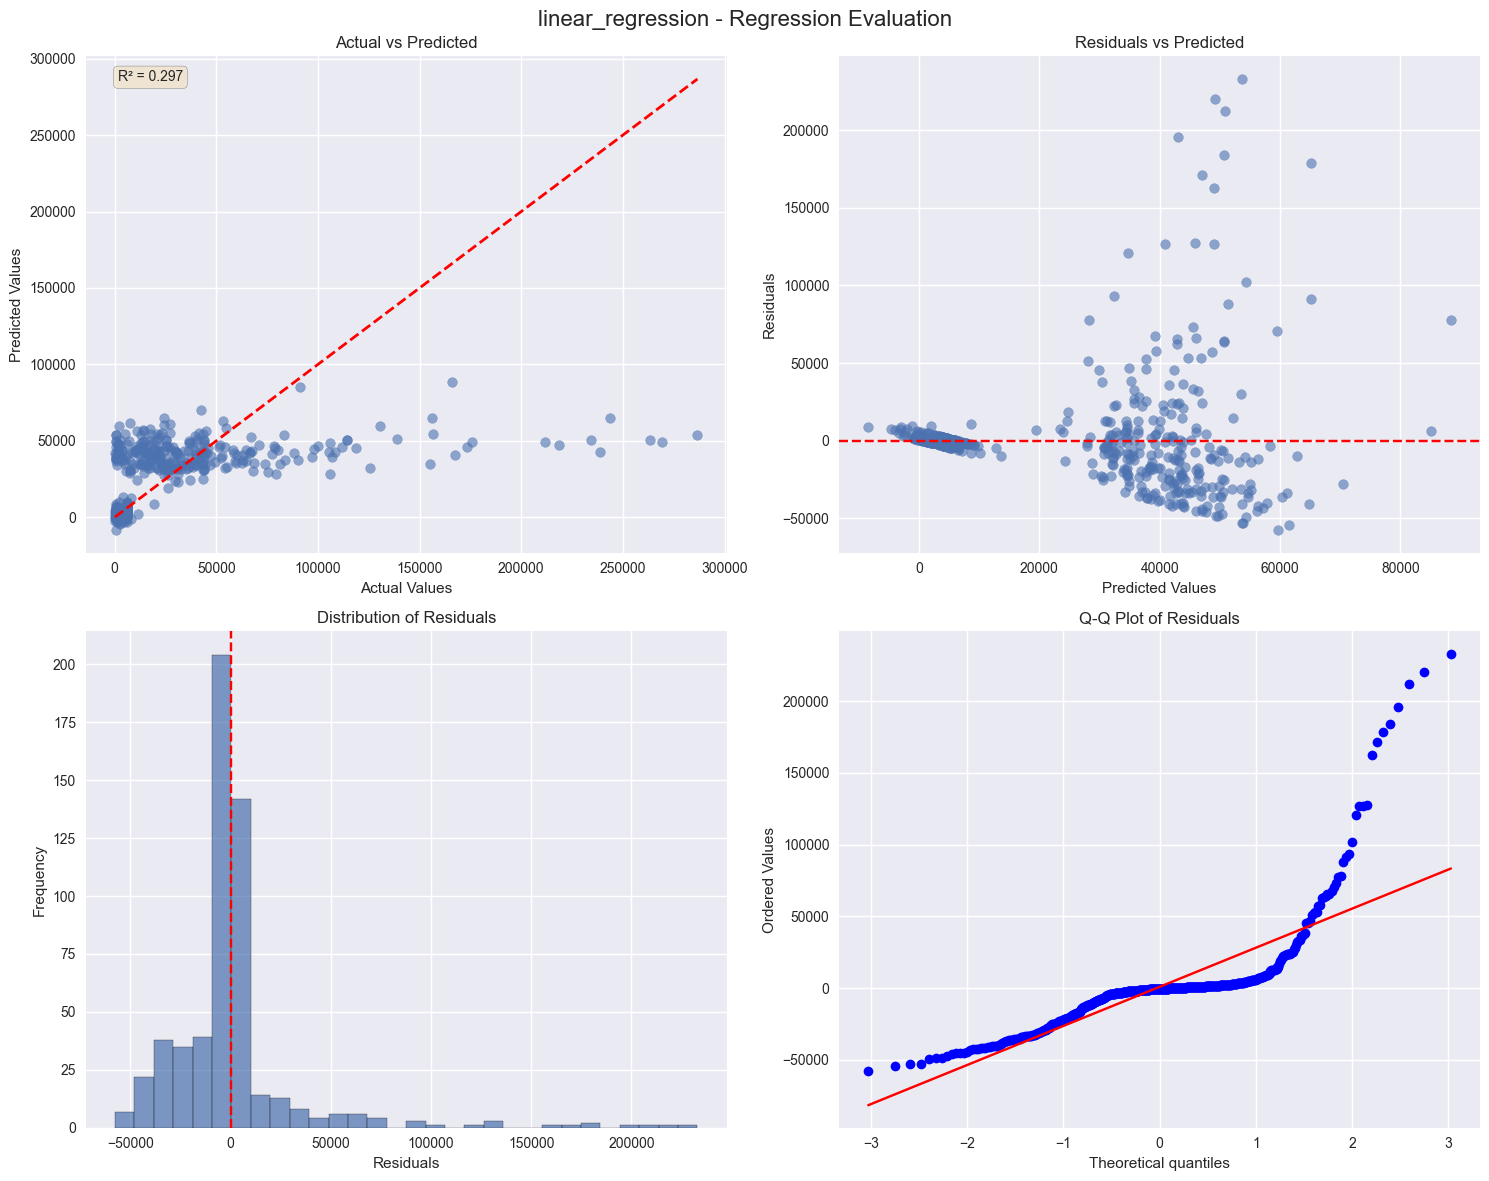

In [13]:
# Visualize model performance
best_model_name = comparison_df.iloc[0]['model']
best_model = models[best_model_name]

print(f"\nCreating evaluation plots for best model: {best_model_name}")
evaluator.plot_regression_results(
    best_model, best_model_name, X_test_selected, y_test, 
    save_path='../reports/figures/modeling'
)

## 12. Model Interpretation {#interpretation}

Analyzing feature importance to understand which variables have the greatest impact on claim severity predictions. This provides crucial insights for business decision-making and risk assessment.

INFO:modeling.model_interpreter:Analyzing feature importance for linear_regression
INFO:modeling.model_interpreter:Computing permutation importance...


Performing model interpretation...


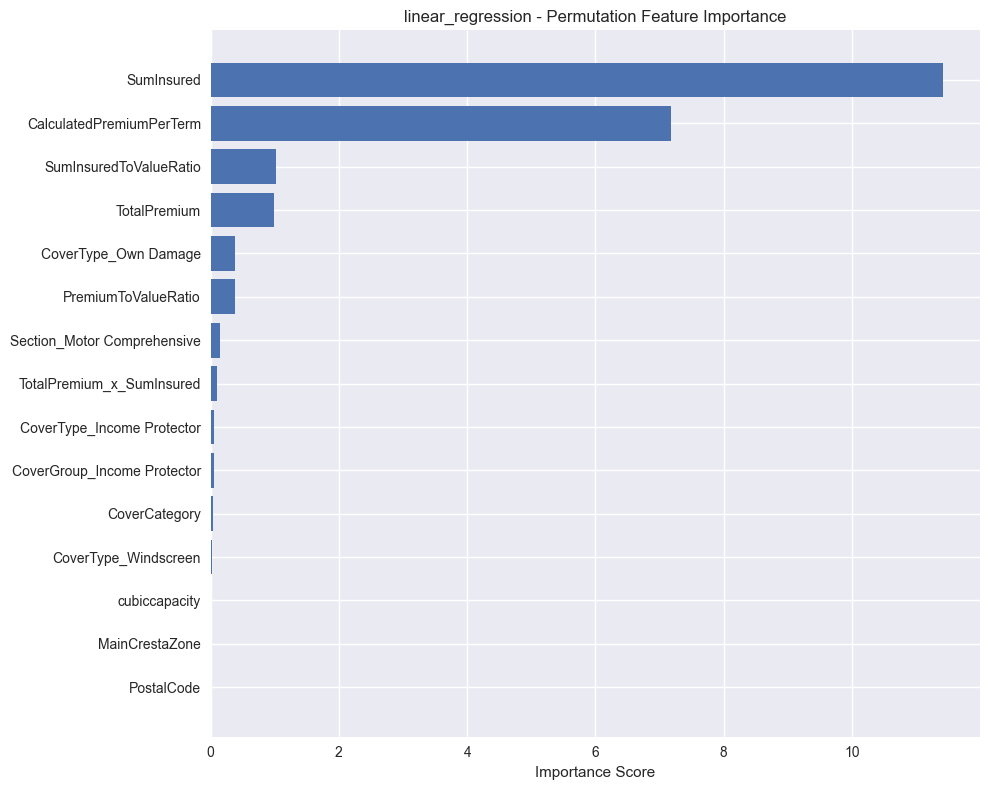

In [14]:
# Model Interpretation
print("Performing model interpretation...")

interpreter = ModelInterpreter()

# Feature importance analysis
feature_importance = interpreter.analyze_feature_importance(
    best_model, best_model_name, X_test_selected, y_test, 
    feature_names=selected_features, top_n=15
)

## 13. SHAP Analysis {#shap}

Computing SHAP (SHapley Additive exPlanations) values to provide detailed explanations of individual predictions and overall feature contributions. This offers deeper insights into model behavior and decision-making process.

INFO:modeling.model_interpreter:Computing SHAP values for linear_regression
ERROR:modeling.model_interpreter:Error computing SHAP values for linear_regression: loop of ufunc does not support argument 0 of type float which has no callable rint method


Computing SHAP values...


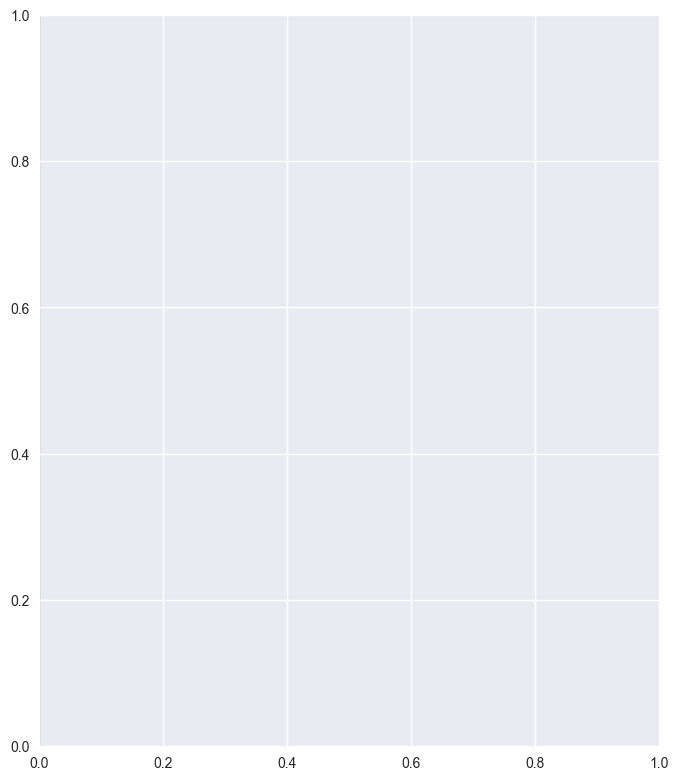

In [15]:
# SHAP Analysis
print("Computing SHAP values...")
shap_values, shap_importance = interpreter.analyze_shap_values(
    best_model, best_model_name, X_train_selected, X_test_selected, 
    feature_names=selected_features, sample_size=100
)

## 14. Business Insights and Recommendations {#insights}

Generating actionable business insights from the model results, including key risk drivers and strategic recommendations for underwriting, pricing, and risk management decisions.

In [16]:
# Business Insights
print("Generating business insights...")
business_insights = interpreter.generate_business_insights(
    best_model_name, feature_names=selected_features
)

print("\nKey Risk Drivers:")
for driver in business_insights['key_risk_drivers'][:5]:
    print(f"- {driver['feature']}: {driver['business_meaning']}")

print("\nBusiness Recommendations:")
for rec in business_insights['business_recommendations']:
    print(f"- {rec}")

Generating business insights...

Key Risk Drivers:

Business Recommendations:


## 15. Model Persistence and Report Generation {#persistence}

Saving the trained models, preprocessing objects, and generating comprehensive evaluation and interpretation reports for future use and documentation purposes.

In [17]:
# Save Models and Results
print("Saving models and results...")

# Create directories if they don't exist
os.makedirs('../models/claim_severity', exist_ok=True)
os.makedirs('../reports/figures/modeling', exist_ok=True)

# Save models
model_trainer.save_models('../models/claim_severity/claim_severity_model')

# Save preprocessing objects
preprocessor.save_preprocessors('../models/claim_severity/preprocessor.joblib')

# Generate evaluation report
evaluation_report = evaluator.generate_evaluation_report(
    save_path='../reports/figures/modeling'
)

# Generate interpretation report
interpretation_report = interpreter.create_interpretation_report(
    best_model_name, save_path='../reports/figures/modeling'
)

print("Claim severity modeling pipeline completed successfully!")

INFO:modeling.model_trainer:Model linear_regression saved to ../models/claim_severity/claim_severity_model_linear_regression.joblib
INFO:modeling.model_trainer:Model decision_tree saved to ../models/claim_severity/claim_severity_model_decision_tree.joblib


Saving models and results...


INFO:modeling.model_trainer:Model random_forest saved to ../models/claim_severity/claim_severity_model_random_forest.joblib
INFO:modeling.model_trainer:Model xgboost saved to ../models/claim_severity/claim_severity_model_xgboost.joblib
INFO:modeling.data_preprocessor:Preprocessing objects saved to ../models/claim_severity/preprocessor.joblib
INFO:modeling.model_evaluator:Evaluation report saved to ../reports/figures/modeling/evaluation_report.json
INFO:modeling.model_interpreter:Interpretation report saved to ../reports/figures/modeling/linear_regression_interpretation_report.json


Claim severity modeling pipeline completed successfully!


## 16. Final Summary and Results {#summary}

Comprehensive summary of the claim severity modeling results including best model performance, key features, and important metrics for business stakeholders.

In [18]:
# Final Results Summary
print("\n" + "="*50)
print("CLAIM SEVERITY MODELING SUMMARY")
print("="*50)

print(f"\nBest Model: {best_model_name}")
print(f"RMSE: {evaluation_results[best_model_name]['rmse']:.2f}")
print(f"R² Score: {evaluation_results[best_model_name]['r2_score']:.4f}")
print(f"MAPE: {evaluation_results[best_model_name]['mape']:.2f}%")

print(f"\nTop 5 Most Important Features:")
if best_model_name in interpreter.feature_importance:
    # Try 'built_in', fallback to 'permutation' or any available key
    importance_dict = interpreter.feature_importance[best_model_name]
    if 'built_in' in importance_dict:
        importance_data = importance_dict['built_in']
    elif 'permutation' in importance_dict:
        importance_data = importance_dict['permutation']
    else:
        # fallback to first available key
        importance_data = next(iter(importance_dict.values()))
    top_features = sorted(importance_data.items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i}. {feature}: {importance:.4f}")

print("\nModel files saved to: ../models/claim_severity/")
print("Evaluation reports saved to: ../reports/figures/modeling/")


CLAIM SEVERITY MODELING SUMMARY

Best Model: linear_regression
RMSE: 33635.71
R² Score: 0.2965
MAPE: 308.91%

Top 5 Most Important Features:
1. SumInsured: 11.4230
2. CalculatedPremiumPerTerm: 7.1714
3. SumInsuredToValueRatio: 1.0185
4. TotalPremium: 0.9872
5. CoverType_Own Damage: 0.3775

Model files saved to: ../models/claim_severity/
Evaluation reports saved to: ../reports/figures/modeling/
